# Example Notebook: Atom Mappings

## Get Data:

LICENSE: Could not open license file "oe_license.txt" in local directory
LICENSE: N.B. OE_LICENSE environment variable is not set
LICENSE: N.B. OE_DIR environment variable is not set
LICENSE: No product keys!
LICENSE: No product keys!
LICENSE: No product keys!
LICENSE: No product keys!


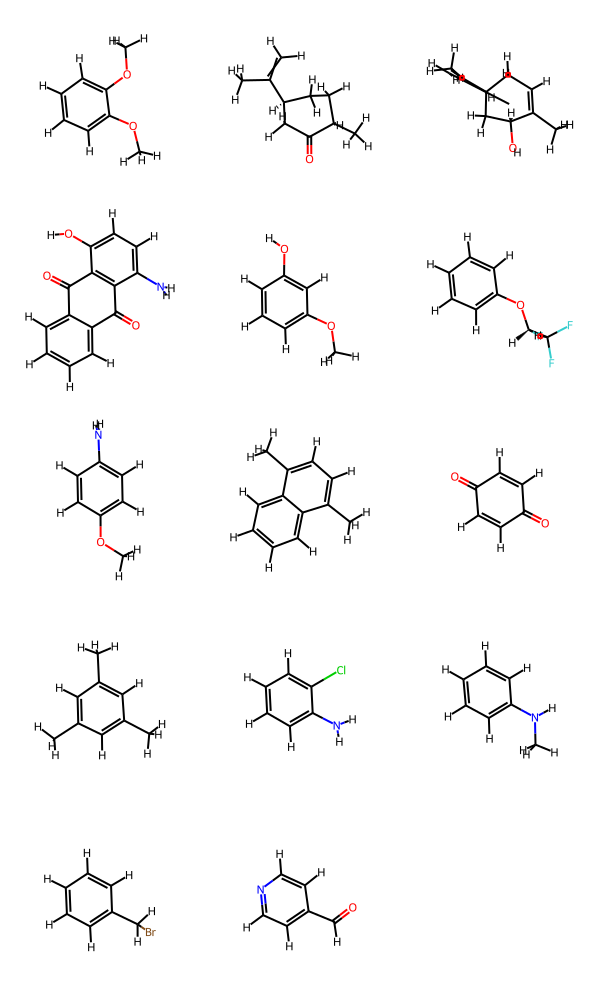

In [1]:
from rdkit import Chem

from openfe_benchmarks import benzenes # get this repository from here: https://github.com/OpenFreeEnergy/openfe-benchmarks

components = benzenes.get_system().ligand_components

# Exclude cycle breakers! as not feasible for Hybrid topology approaches.
not_lig = ["lig_4", "lig_7"]
components = [c for c in components if(c.name not in not_lig)]

Chem.Draw.MolsToGridImage([c.to_rdkit() for c in components])


## Generate Atom Mappings with Kartograf:

In [2]:
from kartograf import KartografAtomMapper

atomMapper = KartografAtomMapper()

#Generate Mappings
mappings = []
cA=components[-5] # central ligand from Ries et al. 2022
for cB in components:
    if(cA != cB):
        mapping = next(atomMapper.suggest_mappings(cA, cB))
        mappings.append(mapping)

INFO:	#################################
INFO:	Map Heavy Atoms 
INFO:	#################################
INFO:	Masking Atoms
INFO:	Build Distance Matrix
INFO:	Calculate Mapping
INFO:	Find Maximal overlapping connected sets of mapped atoms
INFO:	#################################
INFO:	Map Hydrogen Atoms: 
INFO:	#################################
INFO:	Masking Atoms
INFO:	Build Distance Matrix
INFO:	Calculate Mapping
INFO:	Find Maximal overlapping connected sets of mapped atoms
INFO:	#################################
INFO:	Map Heavy Atoms 
INFO:	#################################
INFO:	Masking Atoms
INFO:	Build Distance Matrix
INFO:	Calculate Mapping
INFO:	Find Maximal overlapping connected sets of mapped atoms
INFO:	#################################
INFO:	Map Hydrogen Atoms: 
INFO:	#################################
INFO:	Masking Atoms
INFO:	Build Distance Matrix
INFO:	Calculate Mapping
INFO:	Find Maximal overlapping connected sets of mapped atoms
INFO:	#################################
INFO

In [3]:
from kartograf.utils.mapping_visualization_widget import display_mappings_3d
display_mappings_3d(mappings)

## Scoring Metrics for Atom mappings:

In [9]:
from kartograf.atom_mapping_scorer import ( DefaultKartografScorer,
                                            MappingVolumeRatioScorer, MappingRMSDScorer,
                                            MappingShapeOverlapScorer, MappingShapeMismatchScorer)

scorer_dict ={
    "score": DefaultKartografScorer(),
    "volume_score": MappingVolumeRatioScorer(),
    "rmsd_score": MappingRMSDScorer(),
    "overlap_score": MappingShapeOverlapScorer(),
    "mismatch_score": MappingShapeMismatchScorer()
}

def apply_scorers(mapping):
    for score_name, scorer in scorer_dict.items():
        setattr(mapping, score_name, scorer(mapping))

#score mappings:
for mapping in mappings:
    apply_scorers(mapping)



INFO:	Kartograf Score:
INFO:		MappingVolumeRatioScorer	0.96	weight: 0.1
INFO:		MappingShapeOverlapScorer	0.4	weight: 0.3
INFO:		MappingShapeMismatchScorer	0.24	weight: 0.3
INFO:		MappingRMSDScorer	0.35	weight: 0.3
INFO:	Result: 0.1
INFO:	Kartograf Score:
INFO:		MappingVolumeRatioScorer	0.79	weight: 0.1
INFO:		MappingShapeOverlapScorer	0.45	weight: 0.3
INFO:		MappingShapeMismatchScorer	0.23	weight: 0.3
INFO:		MappingRMSDScorer	0.51	weight: 0.3
INFO:	Result: 0.11
INFO:	Kartograf Score:
INFO:		MappingVolumeRatioScorer	0.77	weight: 0.1
INFO:		MappingShapeOverlapScorer	0.48	weight: 0.3
INFO:		MappingShapeMismatchScorer	0.27	weight: 0.3
INFO:		MappingRMSDScorer	0.54	weight: 0.3
INFO:	Result: 0.12
INFO:	Kartograf Score:
INFO:		MappingVolumeRatioScorer	0.76	weight: 0.1
INFO:		MappingShapeOverlapScorer	0.43	weight: 0.3
INFO:		MappingShapeMismatchScorer	0.18	weight: 0.3
INFO:		MappingRMSDScorer	0.39	weight: 0.3
INFO:	Result: 0.09
INFO:	Kartograf Score:
INFO:		MappingVolumeRatioScorer	0.88	weight

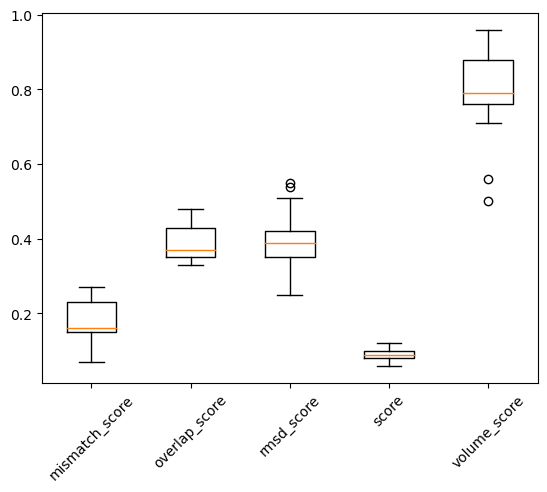

In [5]:
from matplotlib import pyplot as plt

score_names = sorted(scorer_dict)
plt.boxplot([[getattr(m, score_name) for m in mappings] for score_name in score_names])
plt.xticks(range(1, len(score_names)+1), score_names, rotation=45);

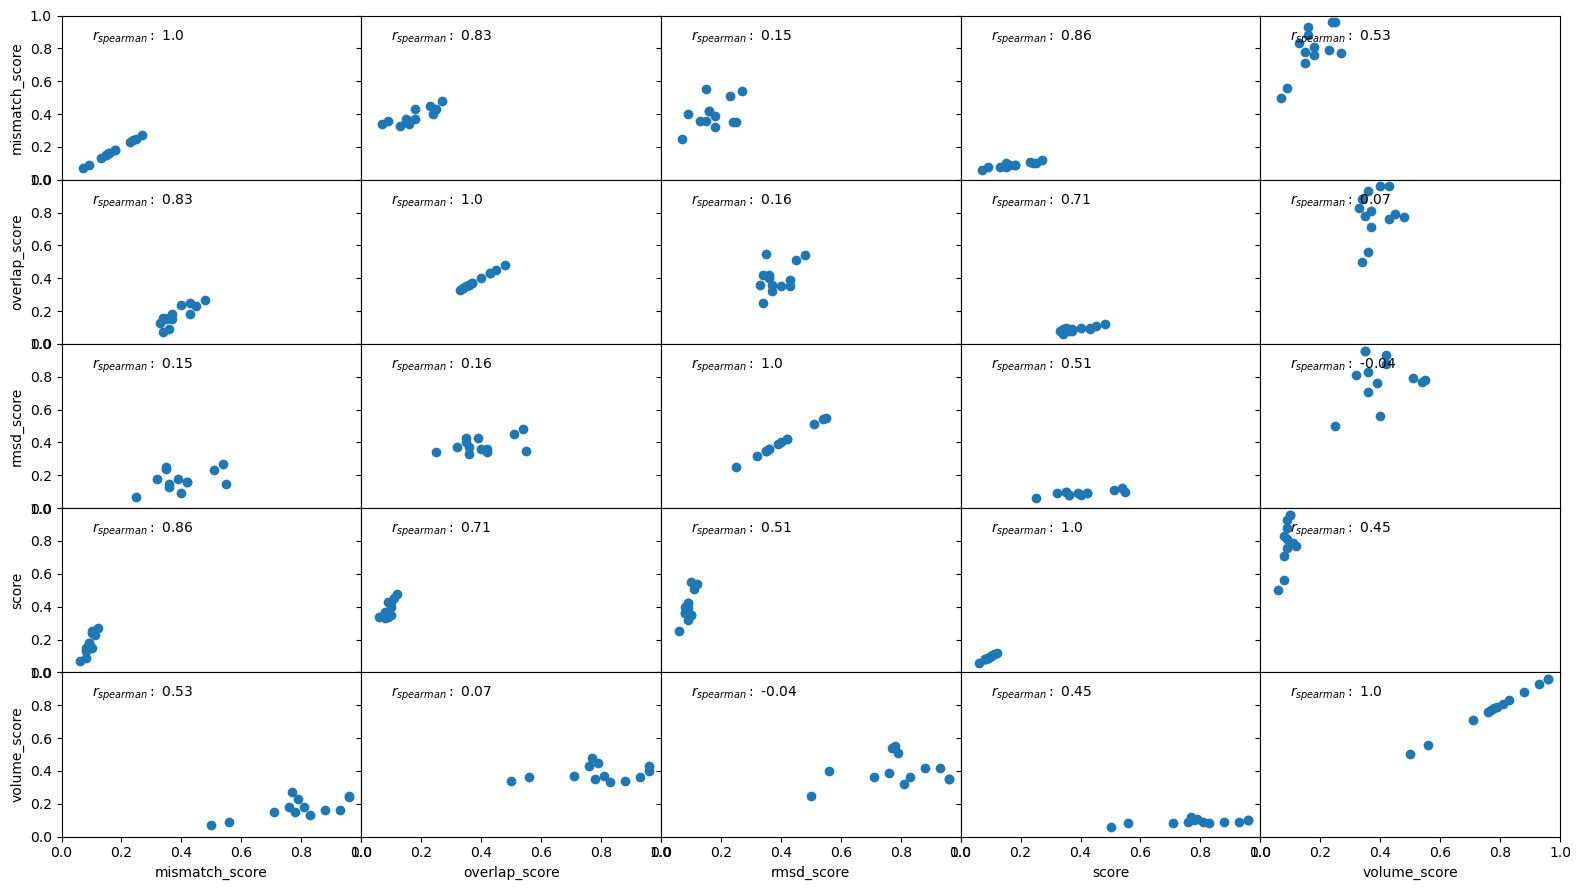

In [6]:
from scipy.stats import spearmanr
from matplotlib import pyplot as plt

score_names = sorted(scorer_dict)
fig, axes = plt.subplots(nrows=len(score_names), ncols=len(score_names), figsize=[16,9])

i=0
for score_nameA in score_names:
    j=0
    axes[i,j].set_ylabel(score_nameA)

    for score_nameB in score_names:
        ax = axes[i,j]
        if(i == len(score_names)-1):
            ax.set_xlabel(score_nameB)
        else:
            ax.set_xticklabels([])
        if(j>0):
            ax.set_yticklabels([])


        x = [getattr(m, score_nameA) for m in mappings]
        y = [getattr(m, score_nameB) for m in mappings]
        r, _ = spearmanr(x,y)
        ax.scatter(x,y)
        ax.text(0.1,0.85, "$r_{spearman}:~$"+str(round(r,2)))
        ax.set_xlim([0,1])
        ax.set_ylim([0,1])

        j+=1
    i+=1
fig.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0)
